In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os

# Change the directory
data_path = "/content/drive/MyDrive/VAE"
os.chdir(data_path)

In [17]:
def plot_normaldistribution(autoencoder, x_set_2018, y_set_2018, x_set_2019, y_set_2019, x_set_2020, y_set_2020, num_batches=100):
  font = {'family' : 'Times New Roman',
      'weight' : 'normal', # bold
      'size'   : 18}
  matplotlib.rc('font', **font)
  # vmin, vmax = 0, 7
  # normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
  plt.rcParams['savefig.dpi'] = 150 # Image Pixel
  plt.rcParams['figure.dpi'] = 150 # Resolution ratio
  plt.rcParams['figure.figsize'] = (5.0, 3.0) # Set figure_size

  mu_2018, sigma_2018 = autoencoder.encoder(x_set_2018.float())
  mu_2019, sigma_2019 = autoencoder.encoder(x_set_2019.float())
  mu_2020, sigma_2020 = autoencoder.encoder(x_set_2020.float())

  mu_2018_cpu = mu_2018.to('cpu').detach().numpy()
  sigma_2018_cpu = sigma_2018.to('cpu').detach().numpy()
  mu_2019_cpu = mu_2019.to('cpu').detach().numpy()
  sigma_2019_cpu = sigma_2019.to('cpu').detach().numpy()
  mu_2020_cpu = mu_2020.to('cpu').detach().numpy()
  sigma_2020_cpu = sigma_2020.to('cpu').detach().numpy()

  df_data = pd.DataFrame(columns=['mu', 'sigma', "Category", "Year"])
  df_summary = pd.DataFrame(columns=['mu', 'sigma', "Category","Year"])
  df_XY = pd.DataFrame(columns=["value", "Years"])

  df_data["mu"] = np.concatenate((np.mean(mu_2018_cpu, 1), np.mean(mu_2019_cpu, 1), np.mean(mu_2020_cpu, 1)), axis=0)
  df_data["sigma"] = np.concatenate( (abs(np.mean(sigma_2018_cpu, 1)), abs(np.mean(sigma_2019_cpu, 1)), abs(np.mean(sigma_2020_cpu, 1)) ), axis=0)
  df_data["Category"] = np.concatenate((y_set_2018, y_set_2019, y_set_2020), axis=0)
  df_data["Year"] = ["2018" for _ in range(len(y_set_2018)) ] + ["2019" for _ in range(len(y_set_2019)) ] + ["2020" for _ in range(len(y_set_2020)) ]

  def plotWeekdayWeekend( day):
    df_summary = pd.DataFrame(columns=['mu', 'sigma', "Category", "Year"])
    df_summary.loc[0] = df_data[ (df_data['Year'] == "2018") & (df_data['Category'] == day) ].mean()
    df_summary.loc[1] = df_data[(df_data['Year'] == "2019") & (df_data['Category'] == day)].mean()
    df_summary.loc[2] = df_data[(df_data['Year'] == "2020") & (df_data['Category'] == day)].mean()
    df_summary["Year"] = np.array(("2018", "2019", "2020"))

    df_XY = pd.DataFrame(columns=["value", "Years", "Category"])
    values, labels, categories = np.array([]), np.array([]), np.array([])
    for i in range(3):
        normal_x = np.random.normal(loc=df_summary.iloc[i][0], scale=df_summary.iloc[i][1], size=100)*10**4
        values = np.concatenate((values, normal_x), axis=0)
        label = [df_summary.iloc[i][3] for _ in range(100)]
        labels = np.concatenate((labels, label), axis=0)
        category = [df_summary.iloc[i][2] for _ in range(100)]
        categories = np.concatenate((categories, category), axis=0)

    df_XY["value"] = values
    df_XY["Years"] = labels
    df_XY["Category"] = categories

    return df_XY

  for day in range(8):
    temp = plotWeekdayWeekend(day)
    sns.displot(temp, x="value", hue="Years", palette=['#2ca02c', '#ff7f0e', '#1f77b4'], alpha=0.2, kind="kde", fill=True)

    plt.ylabel("pdf")
    plt.xlabel("Extracted features $(10^{-4})$")

def plot_joint(autoencoder, x_set, y_set, num_batches=100):
    font = {'family' : 'Times New Roman',
        'weight' : 'normal', # bold
        'size'   : 18}
    matplotlib.rc('font', **font)
    # vmin, vmax = 0, 7
    # normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
    plt.rcParams['savefig.dpi'] = 200 # Image Pixel
    plt.rcParams['figure.dpi'] = 200 # Resolution ratio
    plt.rcParams['figure.figsize'] = (5.0, 3.0) # Set figure_size
    
    df_data = pd.DataFrame(columns=["mu", "sigma", "Category"])
    df_summary = pd.DataFrame(columns=["mu", "sigma", "Category"])

    mu, sigma = autoencoder.encoder(x_set.float())
    mu_cpu = mu.to('cpu').detach().numpy()
    sigma_cpu = sigma.to('cpu').detach().numpy()

    df_data["mu"] = np.mean(mu_cpu, 1)*10**4
    df_data["sigma"] = abs(np.mean(sigma_cpu, 1))*10**4
    df_data["Category"] = y_set
    daylist = ["Night", "Monday_day", "Tuesday_day", "Wednesday_day", "Thursday_day", "Friday_day", "Saturday_day", "Sunday_day"]
    for i in range(8):
        df_summary.loc[i] = df_data[df_data["Category"] == i].mean()

    df_data_revised = df_data
    for i in range(8):
        df_data_revised = df_data_revised.replace(i, daylist[int(df_summary.iloc[i][2])])

    # bivariate relational or distribution plot with the marginal distributions of the mu and sigma
    h = sns.jointplot(data=df_data_revised, x="mu", y="sigma", hue="Category") #xlim = (-200,150), ylim = (-10,130)
    h.ax_joint.set_xlabel("Average $\mu$ $(10^{-4})$")
    h.ax_joint.set_ylabel("Average $\sigma$ $(10^{-4})$")
    
    # plt.xlim([-10, 80])
    # plt.ylim([-10, 40])
    h.ax_joint.legend_._visible=False
    h.fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, borderaxespad=0)
    # plt.tight_layout()
    plt.show()

def plotYearCompare(autoencoder, x_set_2018, y_set_2018, x_set_2019, y_set_2019, x_set_2020, y_set_2020, num_batches=100):

    mu_2018, sigma_2018 = autoencoder.encoder(x_set_2018.float())
    mu_2019, sigma_2019 = autoencoder.encoder(x_set_2019.float())
    mu_2020, sigma_2020 = autoencoder.encoder(x_set_2020.float())

    mu_2018_cpu = mu_2018.to('cpu').detach().numpy()*10**4
    sigma_2018_cpu = sigma_2018.to('cpu').detach().numpy()*10**4
    mu_2019_cpu = mu_2019.to('cpu').detach().numpy()*10**4
    sigma_2019_cpu = sigma_2019.to('cpu').detach().numpy()*10**4
    mu_2020_cpu = mu_2020.to('cpu').detach().numpy()*10**4
    sigma_2020_cpu = sigma_2020.to('cpu').detach().numpy()*10**4

    def combine(res, nums1, nums2, nums3):
        res = np.concatenate((res, nums1), axis=0)
        res = np.concatenate((res, nums2), axis=0)
        res = np.concatenate((res, nums3), axis=0)
        return res

    mu_1, mu_2, sigma1, sigma2 = np.array([]), np.array([]), np.array([]), np.array([])
    mu_1 = combine(mu_1, mu_2018_cpu[:, 0], mu_2019_cpu[:, 0], mu_2020_cpu[:, 0])
    mu_2 = combine(mu_2, mu_2018_cpu[:, 1], mu_2019_cpu[:, 1], mu_2020_cpu[:, 1])
    sigma1 = combine(sigma1, sigma_2018_cpu[:, 0], sigma_2019_cpu[:, 0], sigma_2020_cpu[:, 0])
    sigma2 = combine(sigma2, sigma_2018_cpu[:, 1], sigma_2019_cpu[:, 1], sigma_2020_cpu[:, 1])

    year = ["2018" for _ in range(len(mu_2018_cpu))] + ["2019" for _ in range(len(mu_2019_cpu))] +["2020" for _ in range(len(mu_2020_cpu))]

    df_data = pd.DataFrame(columns=["$\mu_1$", "$\mu_2$", "$\sigma_1$", "$\sigma_2$", "Years"])
    df_data["$\mu_1$"], df_data["$\mu_2$"], df_data["$\sigma_1$"], df_data["$\sigma_2$"], df_data["Years"] = mu_1, mu_2, sigma1, sigma2, year

    g = sns.pairplot(df_data, hue="Years", palette="Set2", diag_kind="kde", height=2.5)
    labels = ["$\mu_1$ $(10^{-4})$", "$\mu_2$ $(10^{-4})$", "$\sigma_1$ $(10^{-4})$", "$\sigma_2$ $(10^{-4})$"]
    
    for i in range(4):
      g.axes[i,0].yaxis.set_label_text(labels[i])

    for j in range(4):
      g.axes[3,j].xaxis.set_label_text(labels[j])
        
    plt.show()

In [11]:
import argparse
import numpy as np
import datetime
import json
from scipy.stats import special_ortho_group
import pandas as pd
import VAE_4
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from Data import DatasetVAE
import torch.nn.functional as F
from torchvision.io import read_image
import torchvision
# for creating validation set
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import matplotlib

def show(imgs):

    img = transforms.ToPILImage()(imgs.to(torch.device('cuda:0')))
    plt.imshow(np.asarray(img))
    # plt.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    # recon_loss = F.binary_cross_entropy(recon_x.float().view(-1, 104*104), x.view(-1, 104*104), reduction='sum')
    recon_loss = F.mse_loss(recon_x.float(), x )
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kldivergence /= 104*104
    return recon_loss + variational_beta * kldivergence

def train_CNNmodel(model, dataset, patience=7, n_epochs=25, batch_size=32, verbose=False):

    model.to(torch.device('cuda:0'))
    df = pd.DataFrame(columns=['train_loss', 'valid_loss'])

    # divide data to training and test randomly for every epoch
    # train_x -> torch.Size([4500, 5, 5, 25])
    # train_y -> torch.Size([4500, 8])
    vali_num = int(0.1 * len(dataset))
    train_num = len(dataset) - vali_num
    train_dataset, vali_dataset = random_split(dataset, [train_num, vali_num])

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=vali_dataset, batch_size=batch_size, shuffle=True)

    # define optimizer Adam, SGD with mommentum
    optimizer = Adam(model.parameters(), lr=0.01 ) #learning rate
    # optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0, nesterov=False)

    # Evaluation tool crossEntropyloss
    # criterion = nn.CrossEntropyLoss()

    # Schedule learning rate
    scheduler = MultiStepLR( optimizer, milestones = [25, 45], gamma = 0.1)
    # scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience) # "min" mode or "max" mode

    # to track the training loss as the model trains
    # train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        train_losses, train_num = 0, 0
        for batch, (x, y) in enumerate(train_loader, 0):

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # get the inputs;
            image_batch_recon, latent_mu, latent_logvar, _ = model( x.float().to(device) )

            # output_train, target_train = model( x.to(device) ), y.to(device)
            # _, pred_train = torch.max(output_train, 1)
            # calculate the loss
            loss_train = vae_loss(image_batch_recon.to(device), x.float().to(device), latent_mu.to(device), latent_logvar.to(device))

            # loss_train = criterion(output_train, target_train)
            # loss_train = criterion(output_train.reshape(batch_size), target_train)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss_train.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            # train_losses.append(loss_train.item())
            train_losses += loss_train.item()
            train_num += 1

        #####################
        # validate the model #
        ######################
        # model.eval()  # prep model for evaluation
        # valid_acc, valid_num = 0, 0
        # for (x, y) in valid_loader:
        #
        #     # forward pass: compute predicted outputs by passing inputs to the model
        #     output_val, target_val = model( x.to(device) ), y.to(device)
        #     _, pred_val = torch.max(output_val, 1)
        #     # calculate the loss
        #     loss_val = criterion(output_val, target_val)
        #     # record validation loss
        #     # valid_losses.append(loss_val.item())
        #     valid_acc += torch.sum(pred_val == target_val)
        #     valid_num += target_val.size(0)

        # calculate average loss over an epoch
        train_epoch_loss = train_losses / train_num
        # valid_epoch_acc = valid_acc.double() / valid_num
        # train_loss = np.average(train_losses)
        # valid_loss = np.average(valid_losses)
        # df.loc[epoch] = [train_loss, valid_loss]

        # print training loss, validation loss, and learning rate
        epoch_len = len(str(n_epochs))
        curr_lr = optimizer.param_groups[0]['lr']

        print(f"[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] "
              + f"train_loss: {train_epoch_loss:4.5f}, lr: {curr_lr:4.5f}" )

        # adjust lr
        scheduler.step() # for MultiStepLR
        # scheduler.step( valid_loss) # for ReduceLROnPlateau

        # # clear lists to track next epoch
        # train_losses = []
        # valid_losses = []

    return model, train_loader, valid_loader, df

def to_img(x):
        x = x.clamp(0, 1)
        return x
#
def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def DeNormalize(Inputs, min_value=-1, max_value=1):
    Recover_inputs = min_value + (max_value - min_value)*Inputs
    return Recover_inputs

# if __name__ == '__main__':

# p = argparse.ArgumentParser()
# p.add_argument('-v', '--verbose', action='store_true')
# p.add_argument('-e', '--n_epochs', type=int, default=30, help='number of episodes')
# p.add_argument('--force_cpu', action='store_true', help='Forces CPU usage')
# args = p.parse_args()
device = torch.device('cuda:0')

# original image size [1,224, 224]
# imgSample = read_image(str(Path('featurizers/2019') / '1day.jpg'))
# show(imgSample)

# defining the model
model = VAE_4.VariationalAutoencoder() #, args.net_config
print(model)

variational_beta = 1
dataset_2018 = DatasetVAE(csv_file = ["featurizers/2018/inputAE.csv"],
                         csv_label_file = ["featurizers/2018/AELabel.csv"],
                         root_dir = ["featurizers/2018"],
                         device = device)

dataset_2019 = DatasetVAE(csv_file = ["featurizers/2019/inputAE.csv"],
                    csv_label_file = ["featurizers/2019/AELabel.csv"],
                    root_dir = ["featurizers/2019"],
                    device = device)

dataset_2020 = DatasetVAE(csv_file = ["featurizers/2020/inputAE.csv"],
                    csv_label_file = ["featurizers/2020/AELabel.csv"],
                    root_dir = ["featurizers/2020"],
                    device = device)

# Design the training dataset. Combine the data 2018 and 2019 as the training dataset. 
# dataset = DatasetVAE(csv_file = ["featurizers/2018/inputAE.csv", "featurizers/2019/inputAE.csv"],
#                          csv_label_file = ["featurizers/2018/AELabel.csv", "featurizers/2019/AELabel.csv"],
#                          root_dir = ["featurizers/2018", "featurizers/2019"],
#                          device = device)

# print('Start Training...')
# start = datetime.datetime.now()

# net_trained, train_loader, valid_loader, df = train_CNNmodel(model, dataset_2019)

# end = datetime.datetime.now()

# print("training time", end - start)

# model.load_state_dict(torch.load("your_model_path.pt"))
# net_trained = model

model.load_state_dict(torch.load("VAE_model.pt")) # "your_model_path.pt"
net_trained = model

# from torchsummary import summary
# summary(net_trained, (1,104,104))


VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(3, 3))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (fc_mu): Linear(in_features=1152, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=1152, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=1152, bias=True)
    (conv5): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv4): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv1): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(3, 3))
  )
)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


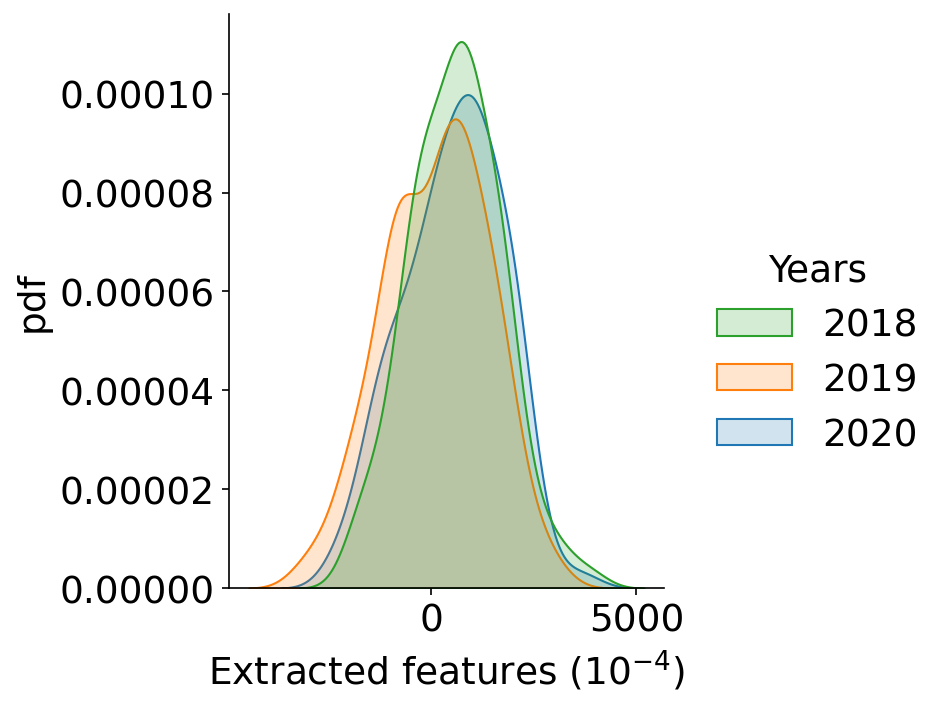

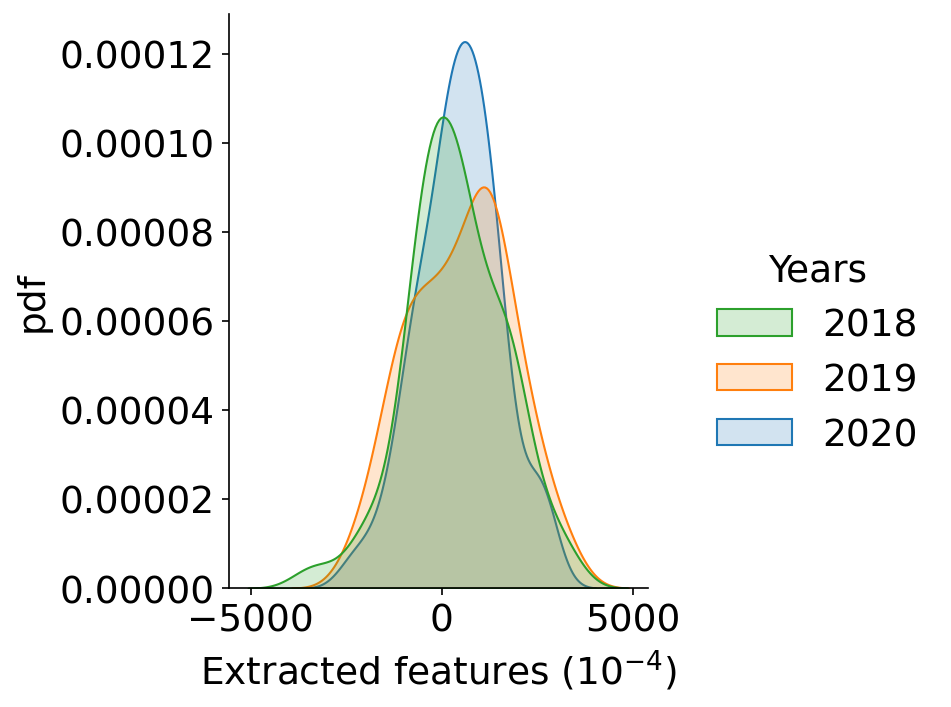

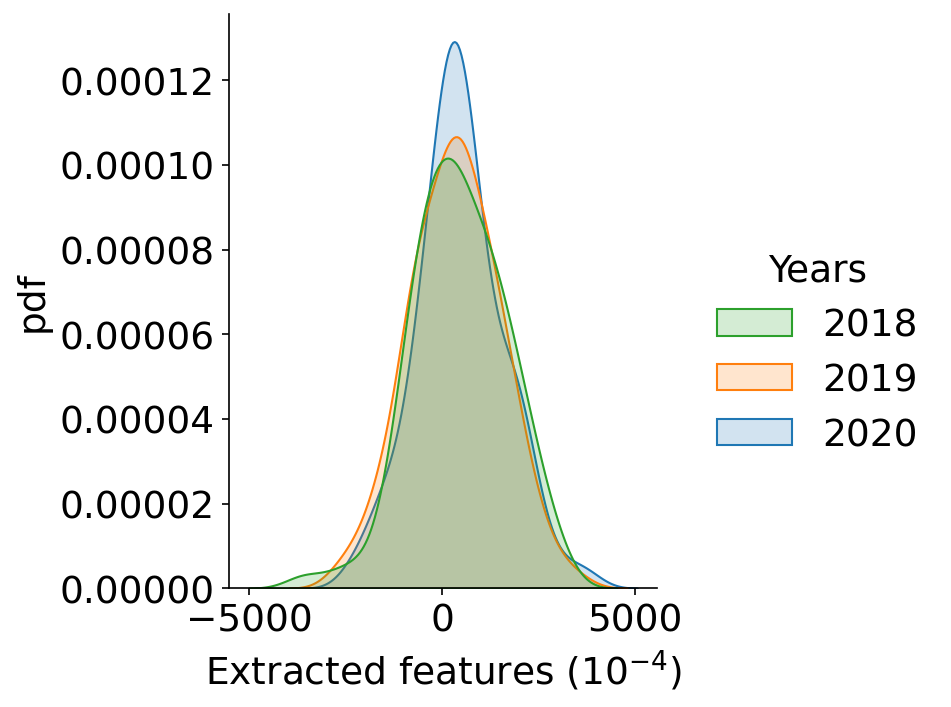

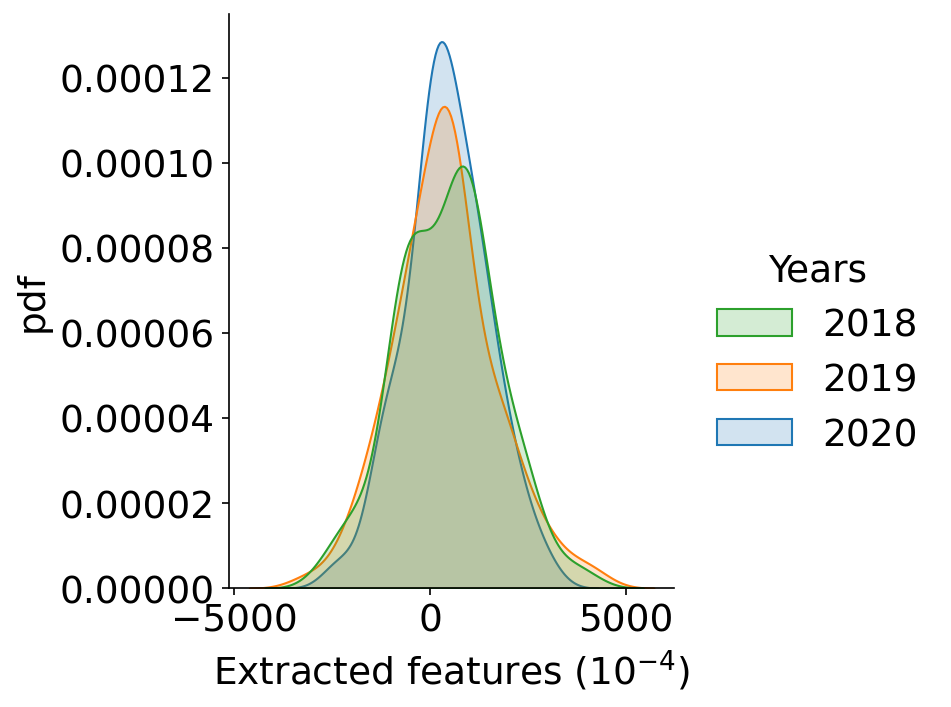

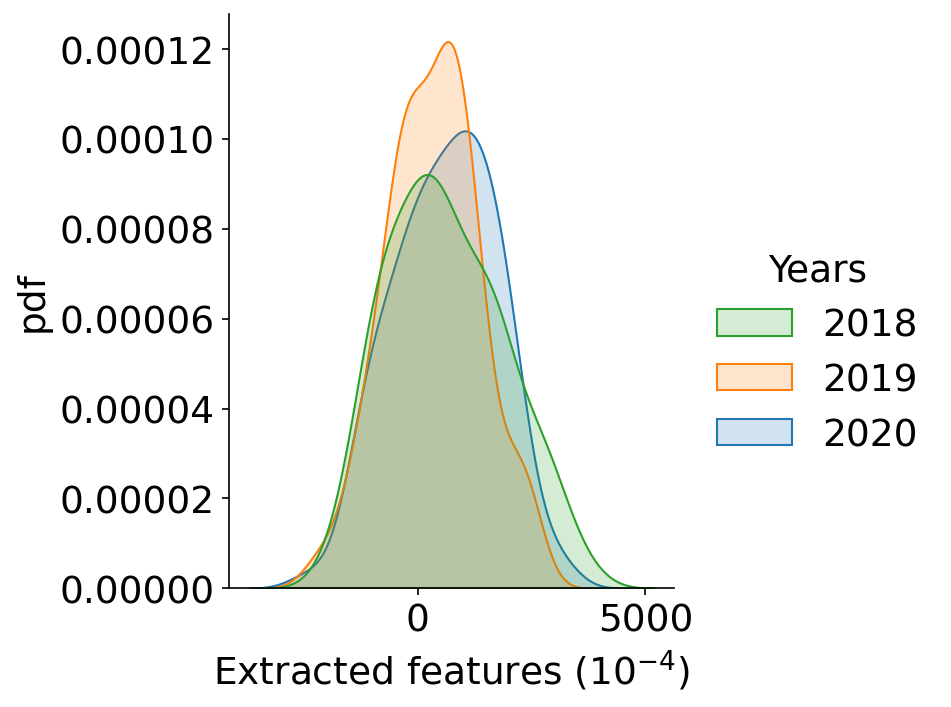

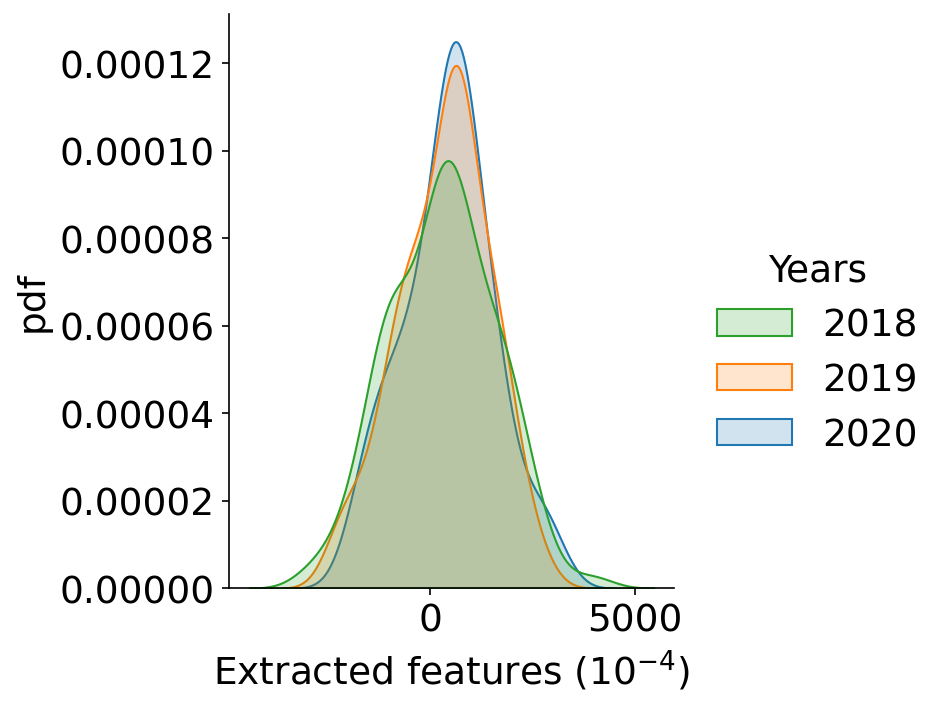

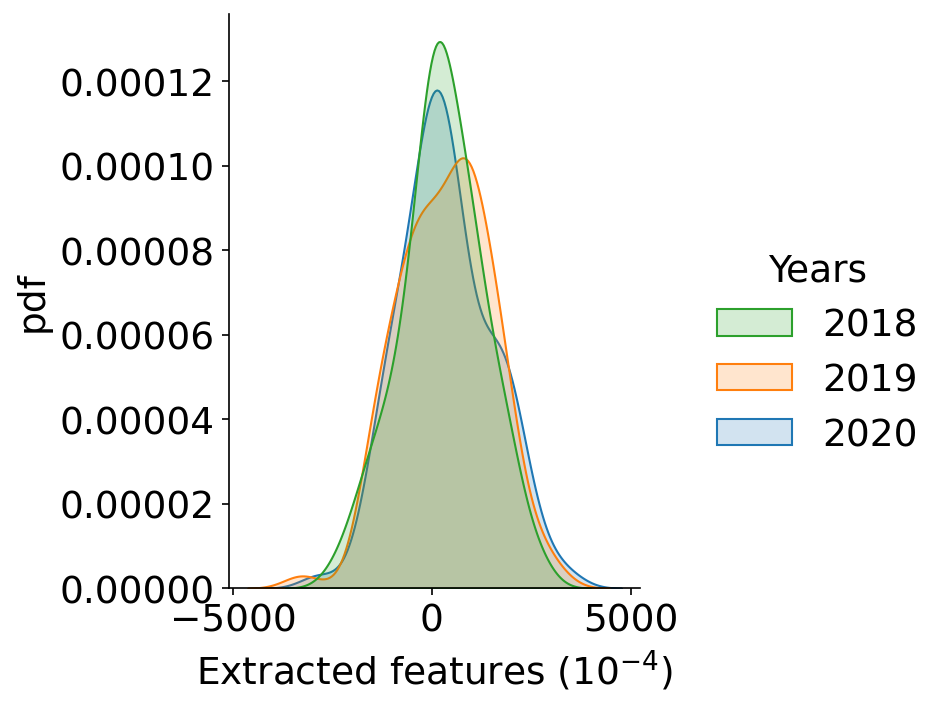

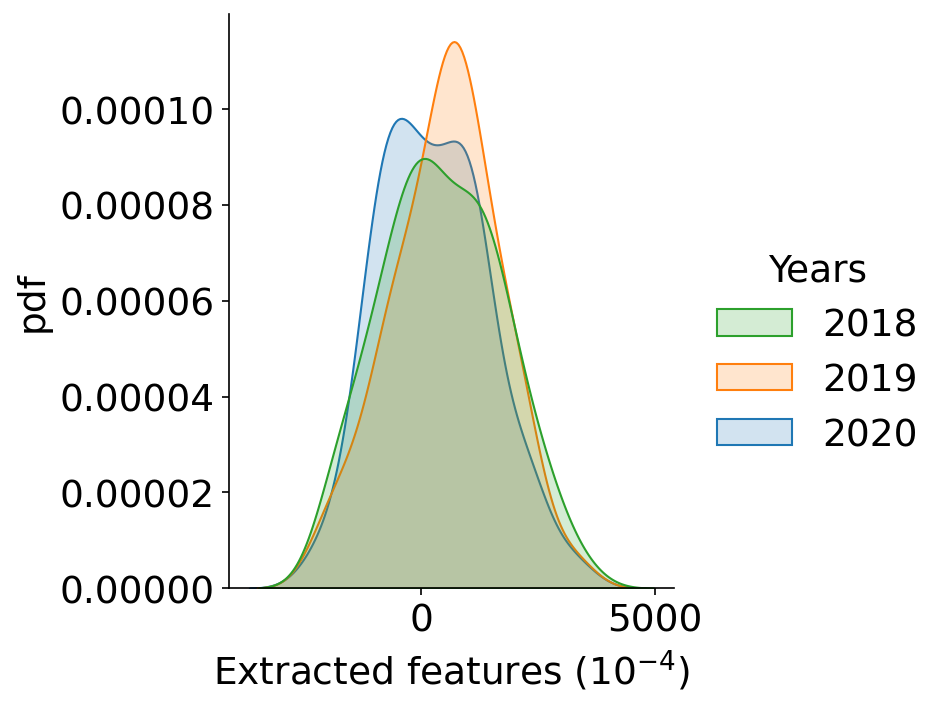

In [12]:
plot_normaldistribution(net_trained, dataset_2018.X, dataset_2018.y_set, dataset_2019.X, dataset_2019.y_set, dataset_2020.X, dataset_2020.y_set)

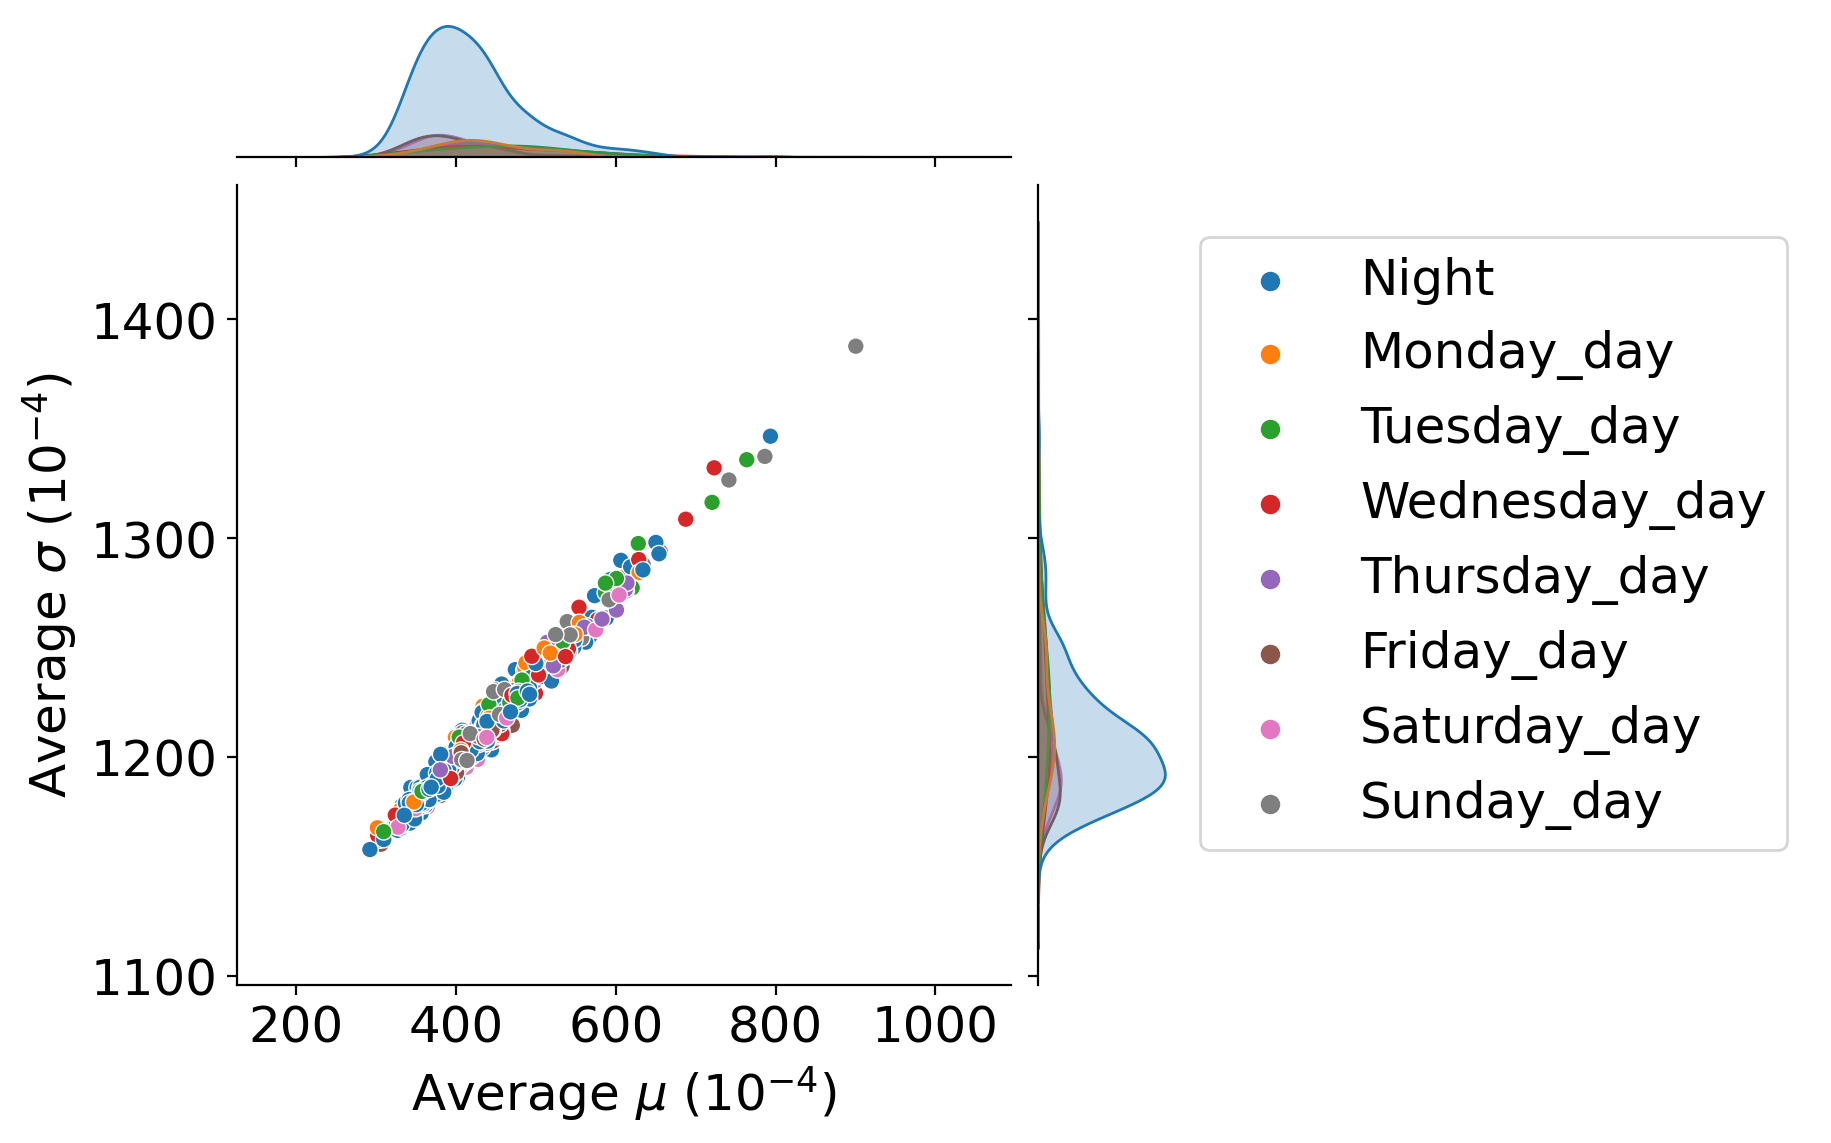

In [18]:
plot_joint(net_trained, dataset_2018.X, dataset_2018.y_set)

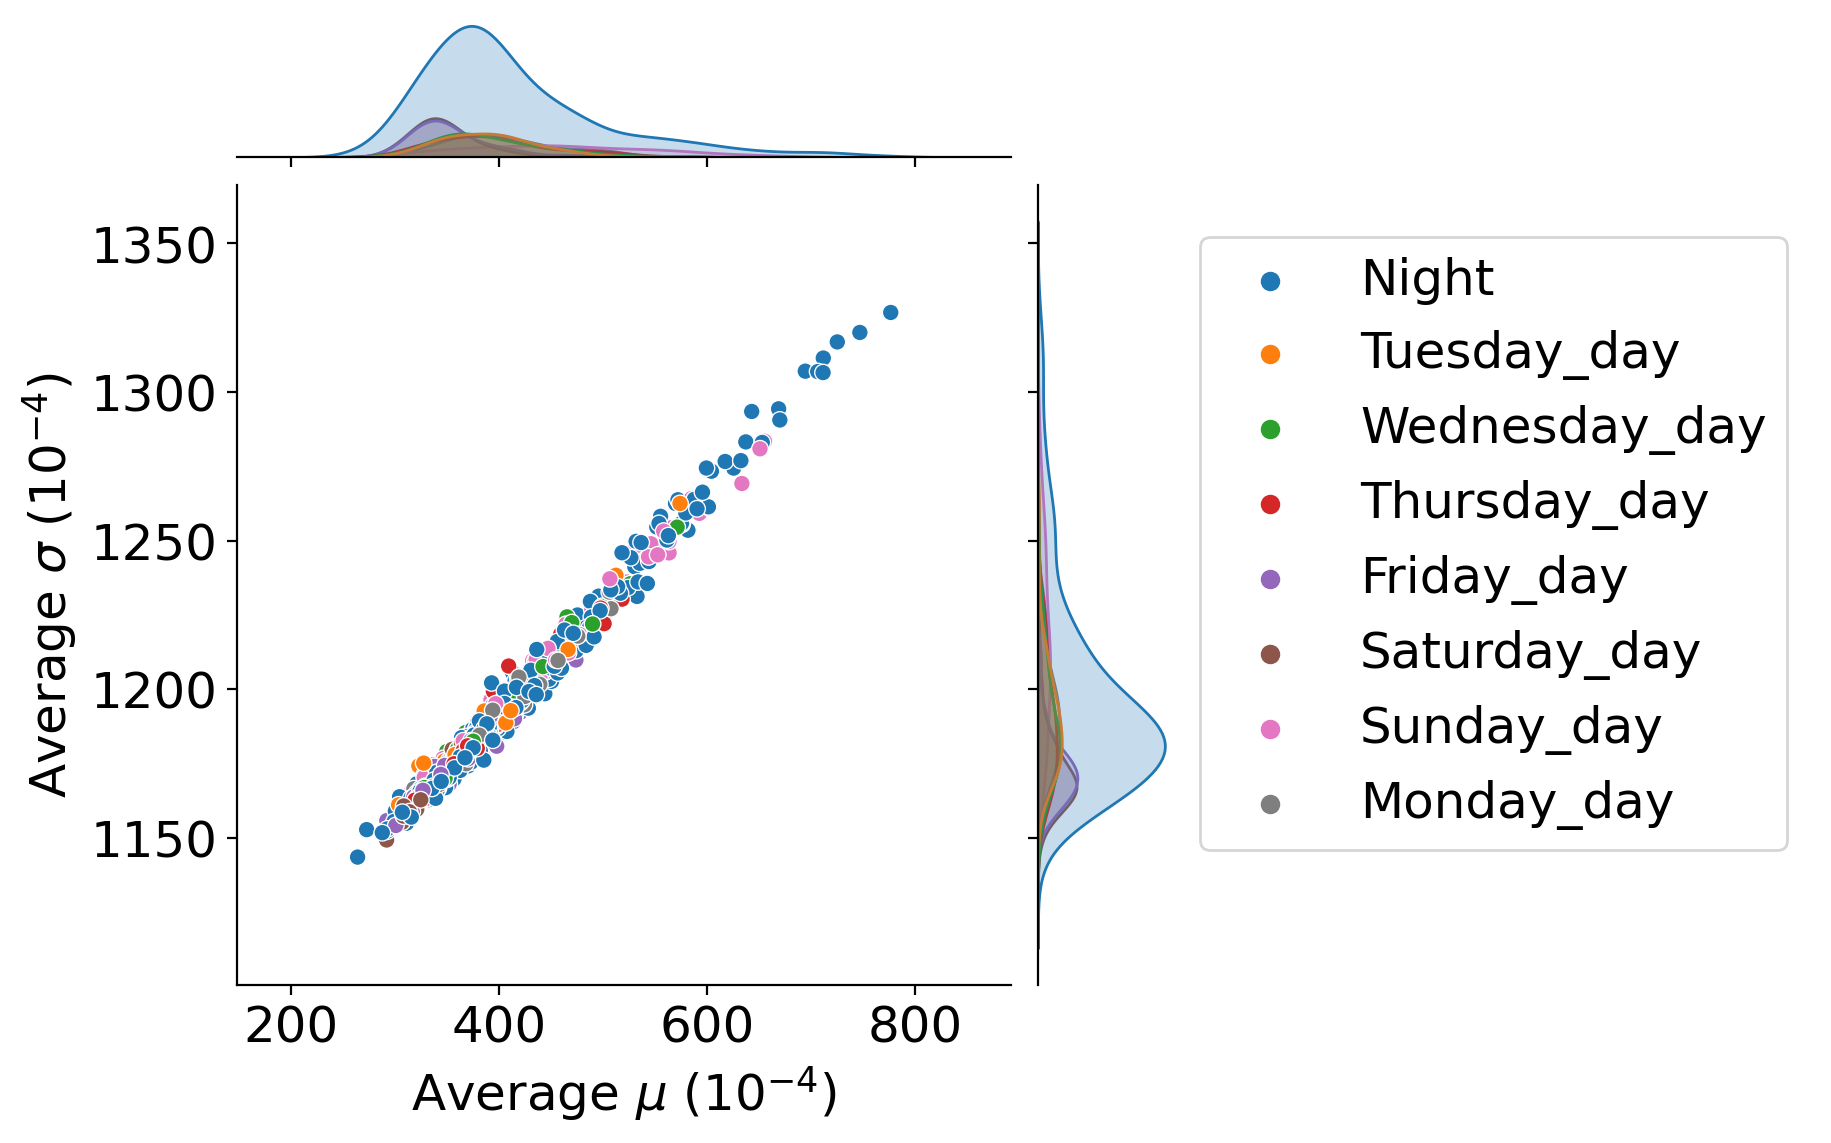

In [19]:
plot_joint(net_trained, dataset_2019.X, dataset_2019.y_set)

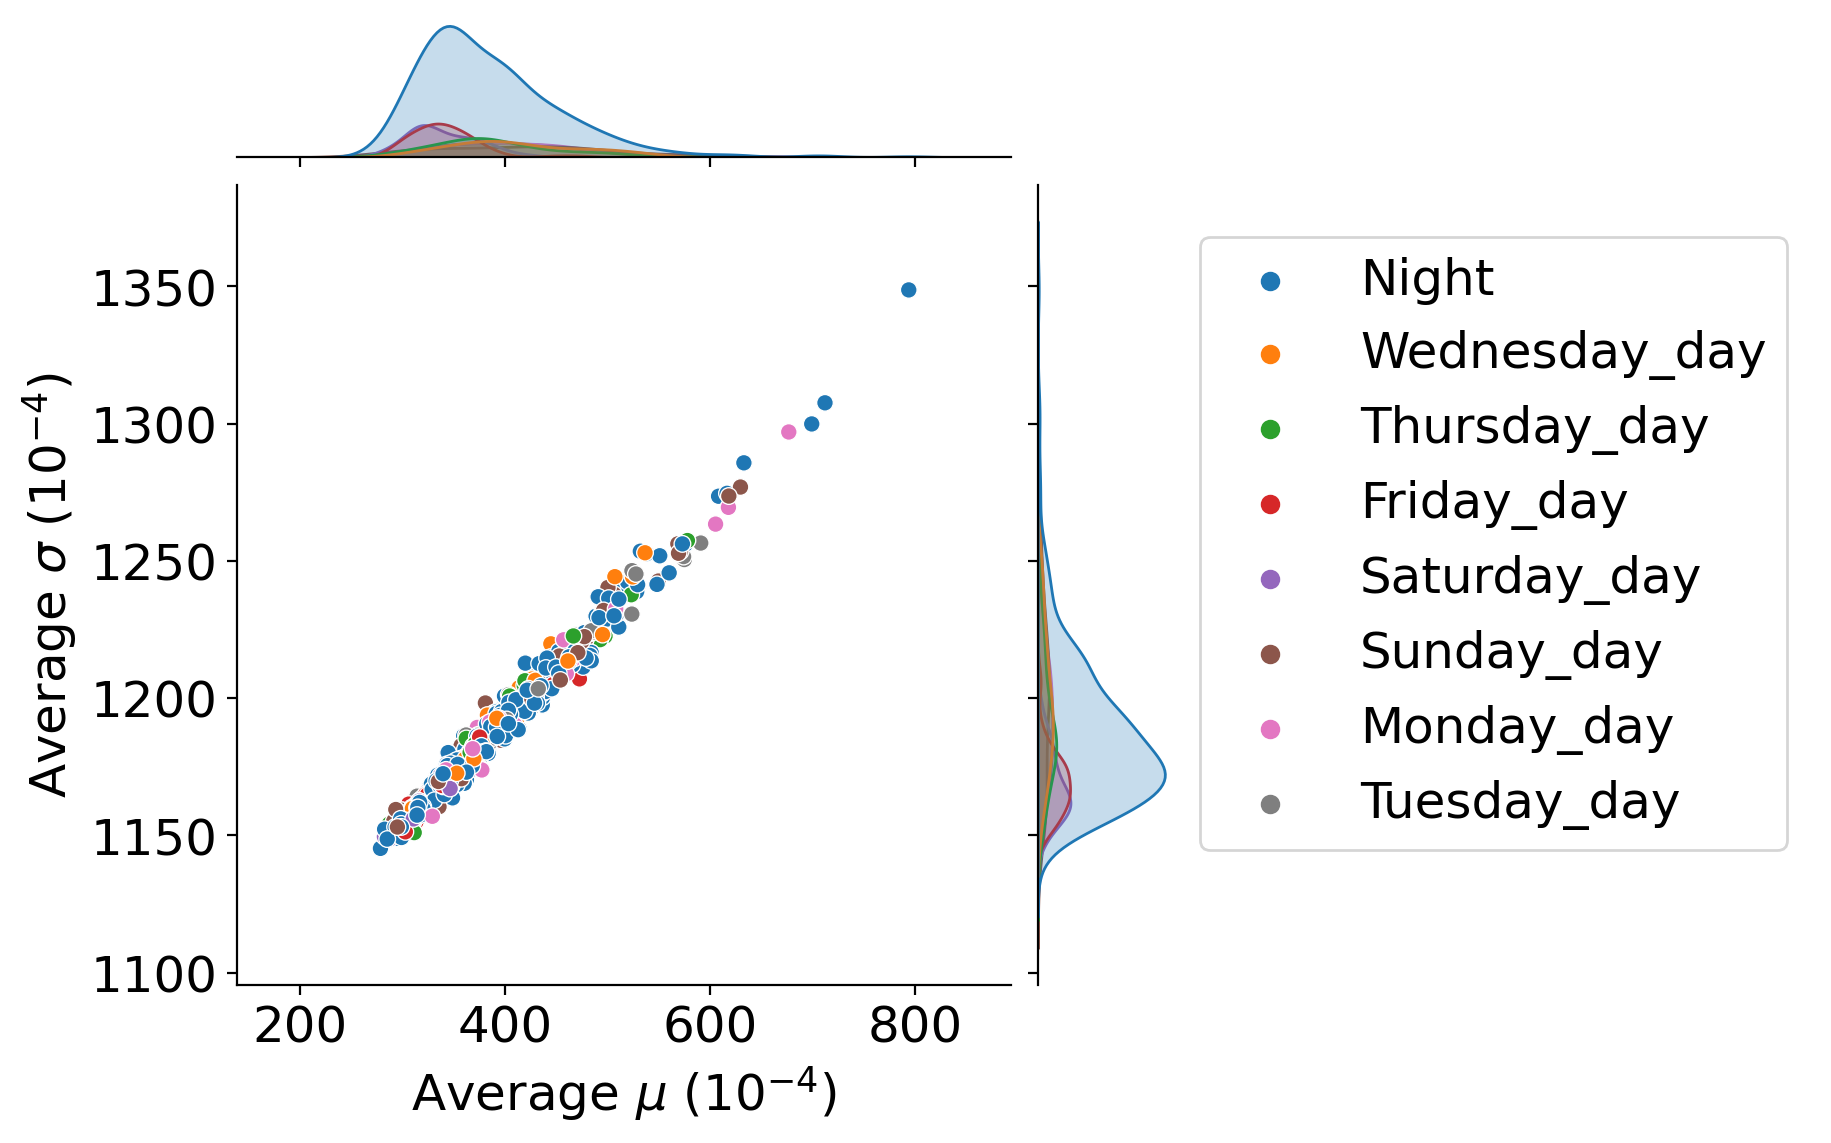

In [20]:
plot_joint(net_trained, dataset_2020.X, dataset_2020.y_set)

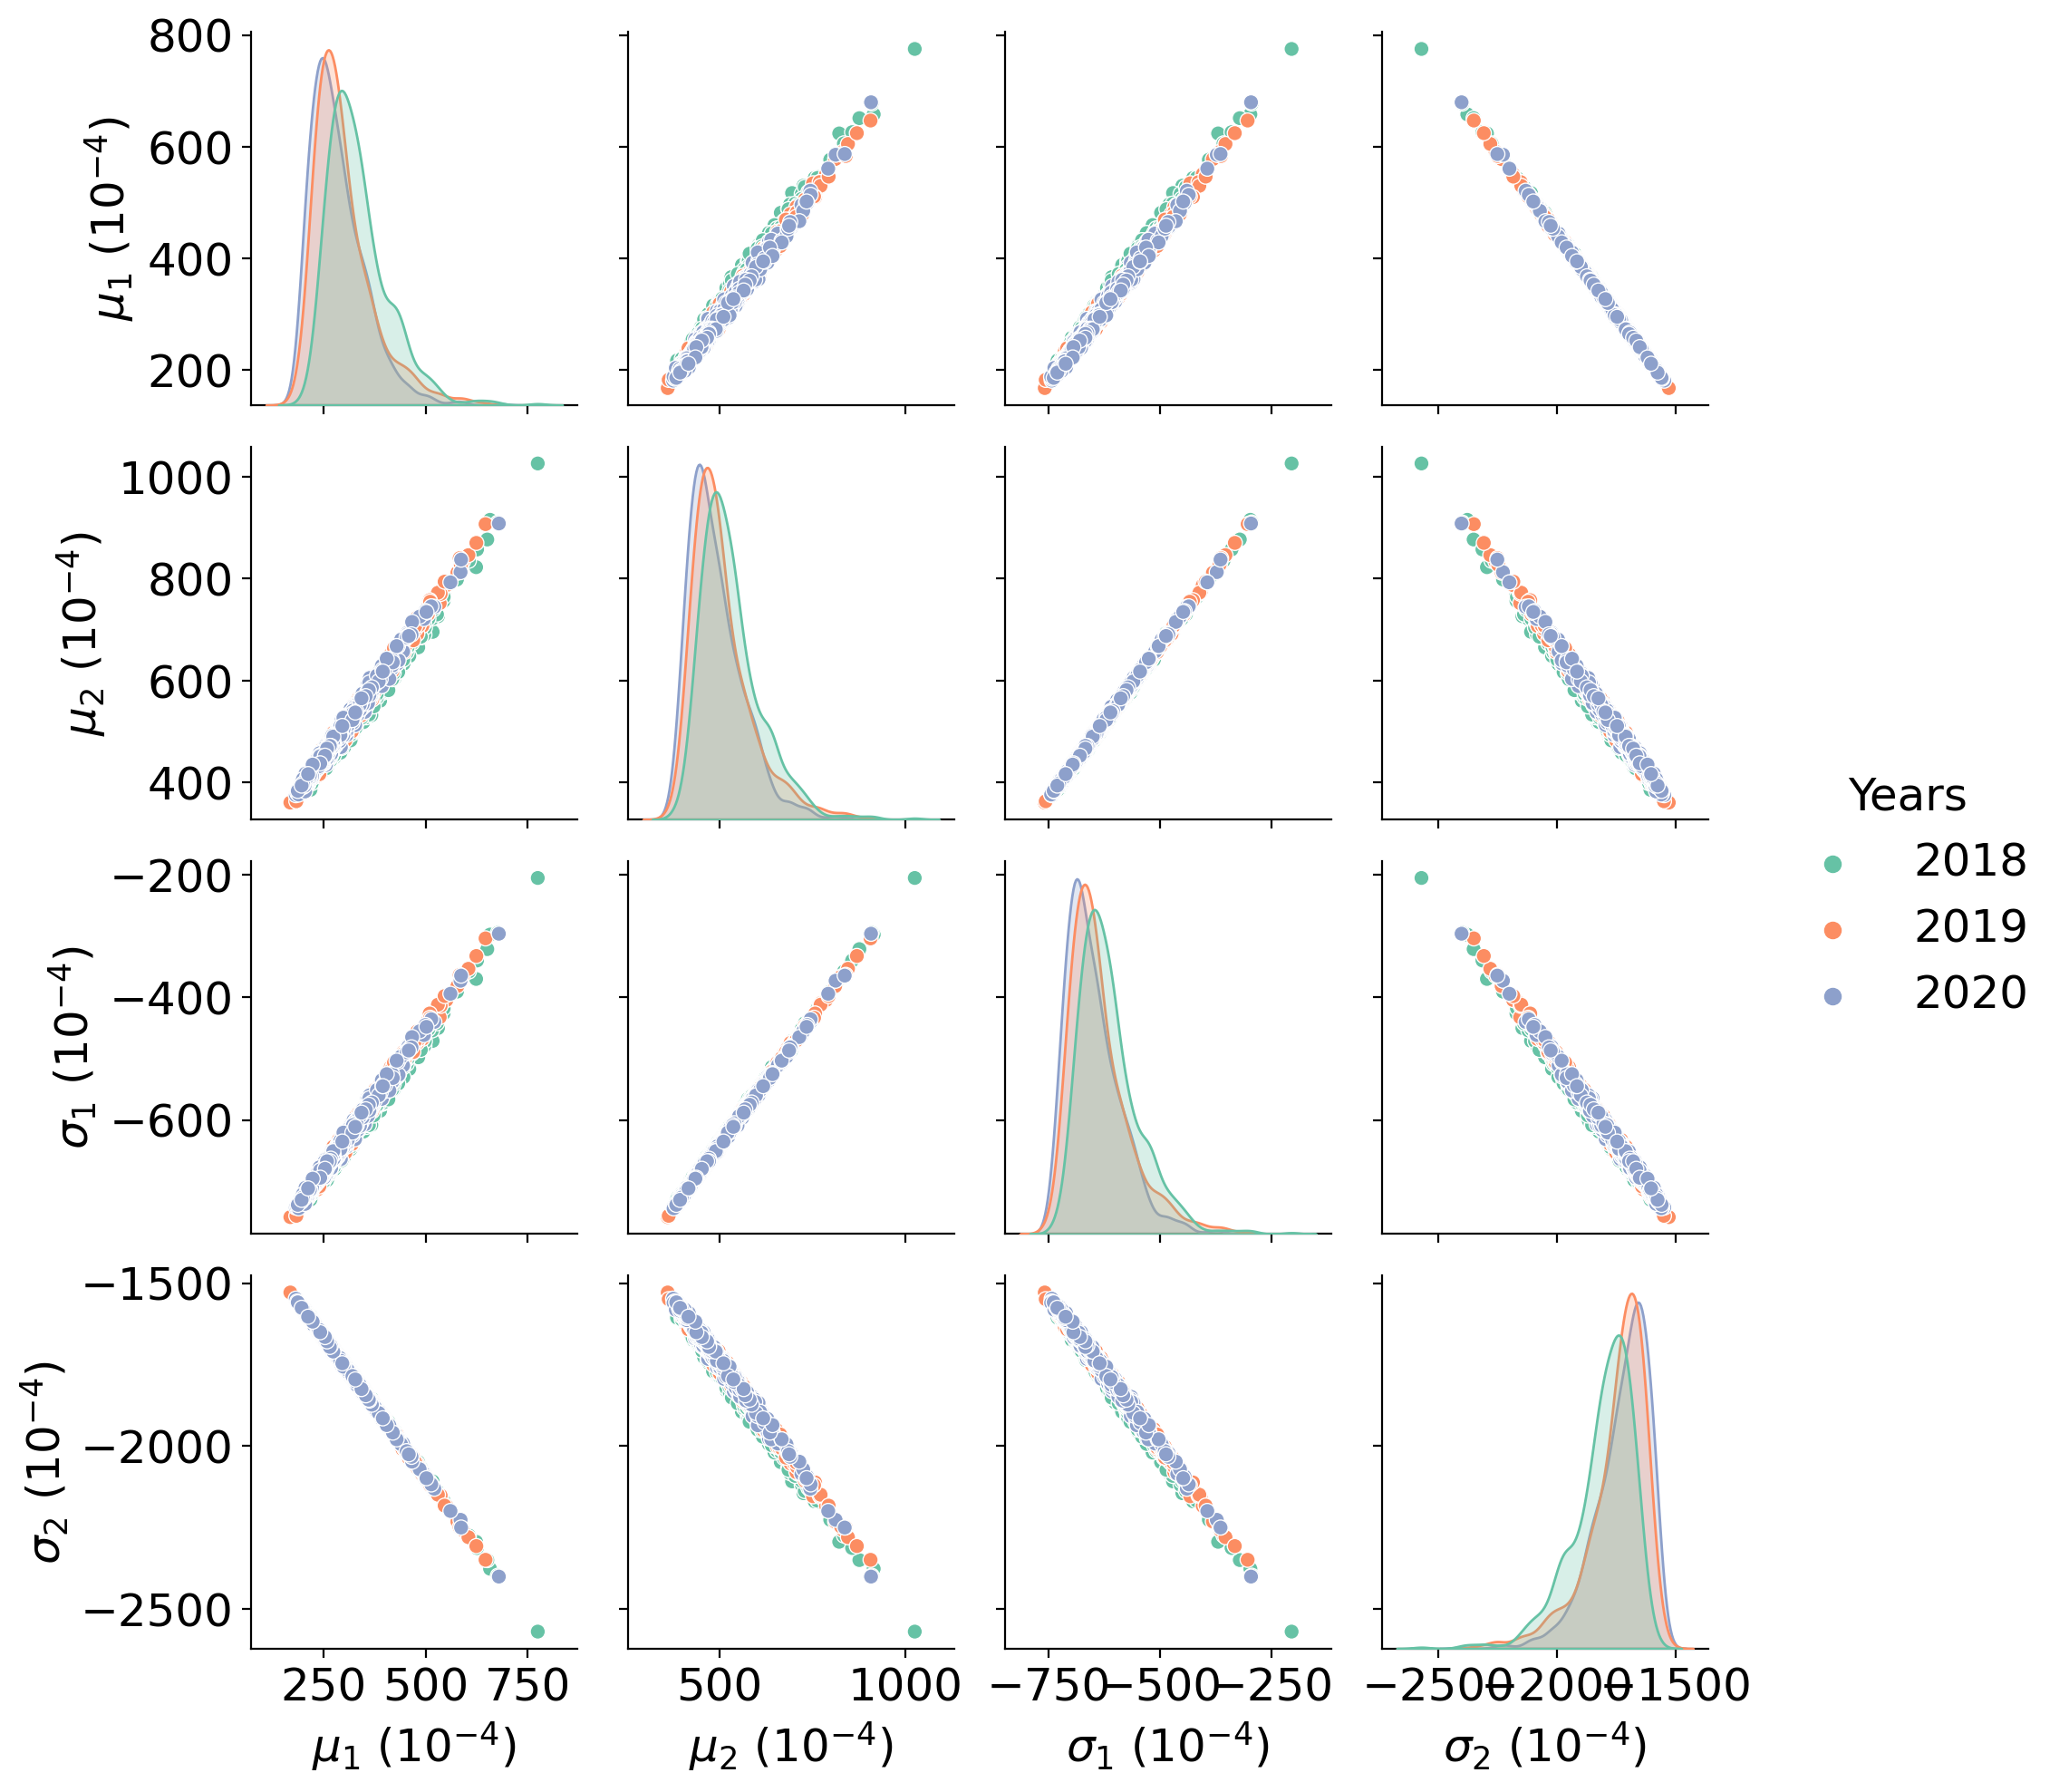

In [16]:
plotYearCompare(net_trained, dataset_2018.X, dataset_2018.y_set, dataset_2019.X, dataset_2019.y_set, dataset_2020.X, dataset_2020.y_set)

In [25]:
def plot_latent(autoencoder, x_set, y_set, num_batches=100):
    font = {'family' : 'Times New Roman',
        'weight' : 'normal', # bold
        'size'   : 12}
    matplotlib.rc('font', **font)

    plt.rcParams['savefig.dpi'] = 120 # Image Pixel
    plt.rcParams['figure.dpi'] = 120 # Resolution ratio
    plt.rcParams['figure.figsize'] = (5.0, 3.0) # Set figure_size

    fig, ax = plt.subplots()

    mu, sigma = autoencoder.encoder(x_set.float()) # x_set.float().to(device)
    mu_cpu = mu.to('cpu').detach().numpy()
    plt.scatter(mu_cpu[:, 0]*10**4, mu_cpu[:, 1]*10**4, c=y_set)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
    # axs[1].xaxis.set_major_formatter('{x:.5f}')
    cbar = plt.colorbar()
    cbar.set_ticks( list(range(8)) )
    cbar.set_ticklabels( ["Night", "Monday_day", "Tuesday_day", "Wednesday_day", "Thursday_day", "Friday_day", "Saturday_day", "Sunday_day"] )

    plt.xlabel("$\mu_1$ $(10^{-4})$" )
    plt.ylabel("$\mu_2$ $(10^{-4})$" )

    # plt.xlim([-10, 30])
    # plt.ylim([5, 50])
    
    plt.tight_layout()
    plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


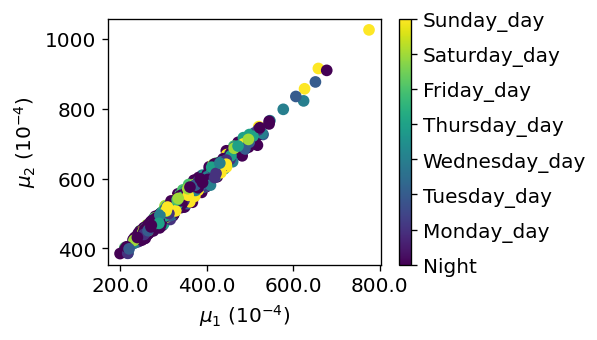

In [26]:
plot_latent(net_trained, dataset_2018.X, dataset_2018.y_set)

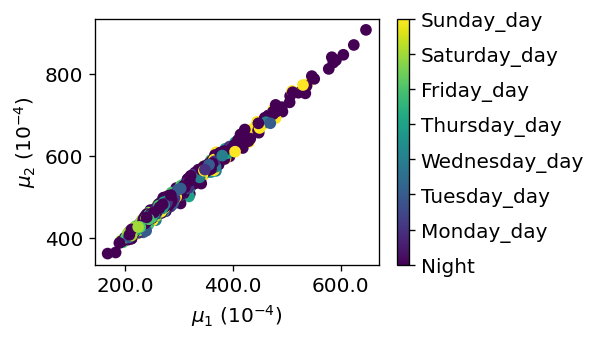

In [27]:
plot_latent(net_trained, dataset_2019.X, dataset_2019.y_set)

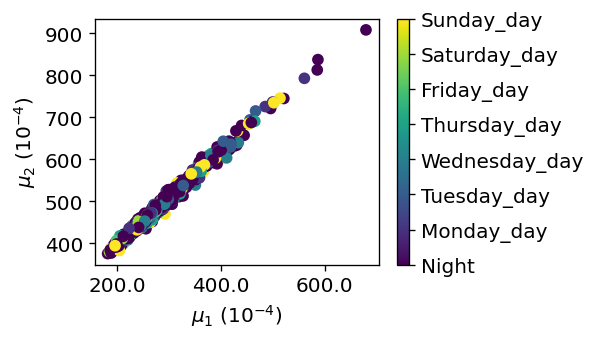

In [28]:
plot_latent(net_trained, dataset_2020.X, dataset_2020.y_set)

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [38]:
def kmeans(autoencoder, x_set_2018, y_set_2018, x_set_2019, y_set_2019, x_set_2020, y_set_2020):

    _, mu_2018, sigma_2018, latent_2018 = autoencoder(x_set_2018.float())
    _, mu_2019, sigma_2019, latent_2019 = autoencoder(x_set_2019.float())
    _, mu_2020, sigma_2020, latent_2020 = autoencoder(x_set_2020.float())

    mu_2018_cpu = mu_2018.to('cpu').detach().numpy()
    sigma_2018_cpu = sigma_2018.to('cpu').detach().numpy()
    muSigma_2018 = np.concatenate([mu_2018_cpu, sigma_2018_cpu], axis=1)
    latent_2018_cpu = latent_2018.to('cpu').detach().numpy().reshape(len(mu_2018),-1)

    mu_2019_cpu = mu_2019.to('cpu').detach().numpy()
    sigma_2019_cpu = sigma_2019.to('cpu').detach().numpy()
    latent_2019_cpu = latent_2019.to('cpu').detach().numpy().reshape(len(mu_2019),-1)
    muSigma_2019 = np.concatenate([mu_2019_cpu, sigma_2019_cpu], axis=1)

    mu_2020_cpu = mu_2020.to('cpu').detach().numpy()
    sigma_2020_cpu = sigma_2020.to('cpu').detach().numpy()
    latent_2020_cpu = latent_2020.to('cpu').detach().numpy().reshape(len(mu_2020),-1)
    muSigma_2020 = np.concatenate([mu_2020_cpu, sigma_2020_cpu], axis=1)

    n_runs = 1
    n_clusters = [5]
    inertia_2018 = np.zeros((len(n_clusters), n_runs))
    inertia_2019 = np.zeros((len(n_clusters), n_runs))
    inertia_2020 = np.zeros((len(n_clusters), n_runs))

    for run in range(n_runs):

        for idx, cluster in enumerate(n_clusters):
            km_2018 = KMeans(n_clusters=cluster).fit(muSigma_2018)
            km_2019 = KMeans(n_clusters=cluster).fit(muSigma_2019)
            km_2020 = KMeans(n_clusters=cluster).fit(muSigma_2020)

            inertia_2018[idx][run] = km_2018.inertia_
            inertia_2019[idx][run] = km_2019.inertia_
            inertia_2020[idx][run] = km_2020.inertia_
    # km_2018, km_2019, km_2020 = kmeansModels[0], kmeansModels[1], kmeansModels[2]
    # plt.errorbar(n_clusters, inertia_2018.mean(axis=1), inertia_2018.std(axis=1), label='2018')
    # plt.errorbar(n_clusters, inertia_2019.mean(axis=1), inertia_2019.std(axis=1), label='2019')
    # plt.errorbar(n_clusters, inertia_2020.mean(axis=1), inertia_2020.std(axis=1), label='2020')
    #
    # plt.legend(loc='best')
    # plt.xlabel('Cluster')
    # plt.ylabel('Sum of squared distances of samples to their closest cluster center')
    # plt.show()
    font = {'family' : 'Times New Roman',
        'weight' : 'normal', # bold
        'size'   : 10}
    matplotlib.rc('font', **font)
    # vmin, vmax = 0, 7
    # normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
    plt.rcParams['savefig.dpi'] = 200 # Image Pixel
    plt.rcParams['figure.dpi'] = 200 # Resolution ratio
    plt.rcParams['figure.figsize'] = (5.0, 3.0) # Set figure_size

    fig = plt.figure(figsize=(8, 3))
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
    n_clusters = 5
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # We want to have the same colors for the same cluster from the MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per closest one.
    means_cluster_centers_2018 = km_2018.cluster_centers_
    order = pairwise_distances_argmin(km_2018.cluster_centers_, km_2019.cluster_centers_)
    means_cluster_centers_2019 = km_2019.cluster_centers_[order]
    order = pairwise_distances_argmin(km_2018.cluster_centers_, km_2020.cluster_centers_)
    means_cluster_centers_2020 = km_2020.cluster_centers_[order]

    means_labels_2018 = pairwise_distances_argmin(muSigma_2018, means_cluster_centers_2018)
    means_labels_2019 = pairwise_distances_argmin(muSigma_2019, means_cluster_centers_2019)
    means_labels_2020 = pairwise_distances_argmin(muSigma_2020, means_cluster_centers_2020)

    clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
    # KMeans_2018
    count = 0
    ax1 = fig.add_subplot(1, 3, 1)
    for k, col in zip(range(n_clusters), colors):
        my_members = means_labels_2018 == k
        cluster_center = means_cluster_centers_2018[k]
        ax1.plot(muSigma_2018[my_members, 0], muSigma_2018[my_members, 1], "w", markerfacecolor=col, marker='o', markersize=6, label=clusters[count])
        ax1.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=8)
        count += 1

    ax1.legend(loc= 'best')
    ax1.set_title('2018')
    ax1.set_xlim([0.01, 0.083])
    ax1.set_ylim([0.03, 0.11])
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')

    # ax.set_xticks(())
    # ax.set_yticks(())

    # KMeans_2019
    count = 0
    ax2 = fig.add_subplot(1, 3, 2)
    for k, col in zip(range(n_clusters), colors):
        my_members = means_labels_2019 == k
        cluster_center = means_cluster_centers_2019[k]
        ax2.plot(muSigma_2019[my_members, 0], muSigma_2019[my_members, 1], "w", markerfacecolor=col, marker='o', markersize=6, label=clusters[count])
        ax2.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=8)
        count += 1

    ax2.legend(loc= 'best')
    ax2.set_title('2019')
    # ax.set_xticks(())
    ax2.set_yticks(())
    ax2.set_xlim([0.01, 0.083])
    ax2.set_ylim([0.03, 0.11])
    ax2.set_xlabel('Dimension 1')

    # KMeans_2020
    df_2020 = pd.DataFrame(columns=['index', 'x', "y"])
    count = 0
    ax3 = fig.add_subplot(1, 3, 3)
    for k, col in zip(range(n_clusters), colors):
        my_members = means_labels_2020 == k
        cluster_center = means_cluster_centers_2020[k]
        print( "Number of samples in the cluster {}: {}".format (count+1, len(muSigma_2020[my_members, 0])) )
        if len(muSigma_2020[my_members, 0]) != 0:
          ax3.plot(muSigma_2020[my_members, 0], muSigma_2020[my_members, 1], "w", markerfacecolor=col, marker='o',
                  markersize=6, label=clusters[count])
          ax3.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=8)
        count += 1

    # Zero-based
    # my_members = means_labels_2020 == k+1
    # cluster_center = means_cluster_centers_2020[k+1]
    # print(cluster_center)
    df_2020['index'] = np.array(range(len(mu_2020)))[my_members]
    df_2020['x'] = muSigma_2020[my_members, 0]
    df_2020['y'] = muSigma_2020[my_members, 1]

    ax3.legend(loc='best')
    ax3.set_title('2020')
    ax3.set_yticks(())
    ax3.set_xlim([0.01, 0.083])
    ax3.set_ylim([0.03, 0.11])
    ax3.set_xlabel('Dimension 1')

    return df_2020

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Number of samples in the cluster 1: 415
Number of samples in the cluster 2: 109
Number of samples in the cluster 3: 21
Number of samples in the cluster 4: 0
Number of samples in the cluster 5: 183


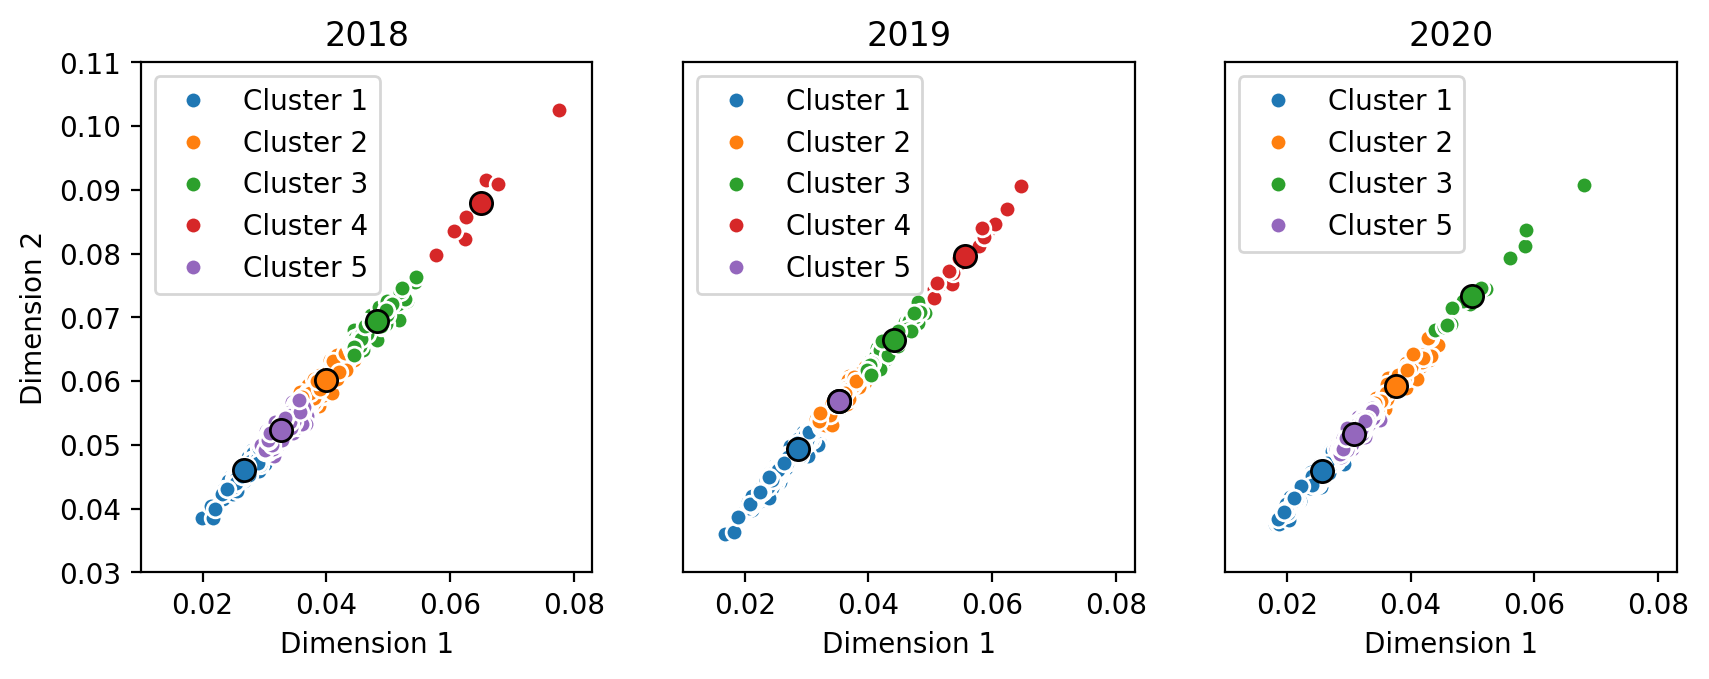

In [39]:
data_2020 = kmeans(net_trained, dataset_2018.X, dataset_2018.y_set, dataset_2019.X, dataset_2019.y_set, dataset_2020.X, dataset_2020.y_set)

In [40]:
def plotElbow(autoencoder, x_set_2018, y_set_2018, x_set_2019, y_set_2019, x_set_2020, y_set_2020):

    _, mu_2018, sigma_2018, latent_2018 = autoencoder(x_set_2018.float())
    _, mu_2019, sigma_2019, latent_2019 = autoencoder(x_set_2019.float())
    _, mu_2020, sigma_2020, latent_2020 = autoencoder(x_set_2020.float())

    mu_2018_cpu = mu_2018.to('cpu').detach().numpy()
    sigma_2018_cpu = sigma_2018.to('cpu').detach().numpy()
    muSigma_2018 = np.concatenate([mu_2018_cpu, sigma_2018_cpu], axis=1)
    latent_2018_cpu = latent_2018.to('cpu').detach().numpy().reshape(len(mu_2018),-1)

    mu_2019_cpu = mu_2019.to('cpu').detach().numpy()
    sigma_2019_cpu = sigma_2019.to('cpu').detach().numpy()
    latent_2019_cpu = latent_2019.to('cpu').detach().numpy().reshape(len(mu_2019),-1)
    muSigma_2019 = np.concatenate([mu_2019_cpu, sigma_2019_cpu], axis=1)

    mu_2020_cpu = mu_2020.to('cpu').detach().numpy()
    sigma_2020_cpu = sigma_2020.to('cpu').detach().numpy()
    latent_2020_cpu = latent_2020.to('cpu').detach().numpy().reshape(len(mu_2020),-1)
    muSigma_2020 = np.concatenate([mu_2020_cpu, sigma_2020_cpu], axis=1)

    n_runs = 5
    n_clusters = [1,2,3,4,5,6,7,8,9,10]
    inertia_2018 = np.zeros((len(n_clusters), n_runs))
    inertia_2019 = np.zeros((len(n_clusters), n_runs))
    inertia_2020 = np.zeros((len(n_clusters), n_runs))

    for run in range(n_runs):

        for idx, cluster in enumerate(n_clusters):
            km_2018 = KMeans(n_clusters=cluster).fit(muSigma_2018)
            km_2019 = KMeans(n_clusters=cluster).fit(muSigma_2019)
            km_2020 = KMeans(n_clusters=cluster).fit(muSigma_2020)

            inertia_2018[idx][run] = km_2018.inertia_
            inertia_2019[idx][run] = km_2019.inertia_
            inertia_2020[idx][run] = km_2020.inertia_

    fig1 = plt.figure()
    font = {'family' : 'Times New Roman',
        'weight' : 'normal', # bold
        'size'   : 10}
    matplotlib.rc('font', **font)

    plt.rcParams['savefig.dpi'] = 200 # Image Pixel
    plt.rcParams['figure.dpi'] = 200 # Resolution ratio
    plt.rcParams['figure.figsize'] = (5.0, 3.0) # Set figure_size

    plt.errorbar(n_clusters, inertia_2018.mean(axis=1), inertia_2018.std(axis=1), label='2018')
    plt.errorbar(n_clusters, inertia_2019.mean(axis=1), inertia_2019.std(axis=1), label='2019')
    plt.errorbar(n_clusters, inertia_2020.mean(axis=1), inertia_2020.std(axis=1), label='2020')
    
    plt.legend(loc='best')
    plt.xlabel('Number of cluster')
    plt.ylabel('SEE') # Sum of squared distances of samples to their closest cluster center
    
    # this is another inset axes over the main axes
    ax2 = plt.axes([0.4, 0.45, .25, .25])
    
    plt.errorbar(n_clusters[2:6], inertia_2018[2:6].mean(axis=1), inertia_2018[2:6].std(axis=1), label='2018')
    plt.errorbar(n_clusters[2:6], inertia_2019[2:6].mean(axis=1), inertia_2019[2:6].std(axis=1), label='2019')
    plt.errorbar(n_clusters[2:6], inertia_2020[2:6].mean(axis=1), inertia_2020[2:6].std(axis=1), label='2020')
    
    ax2.set_xticks(np.arange(3,7))
    ax2.set_xticklabels(('3', '4', '5', '6'))
    plt.xlabel('Number of cluster')
    plt.ylabel('SSE') # Sum of squared distances of samples to their closest cluster center

    plt.show()

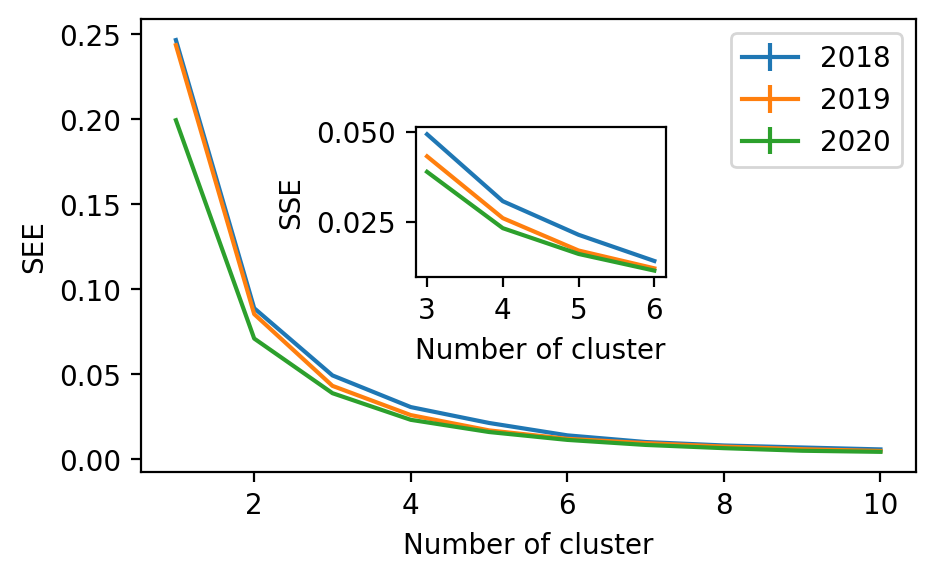

In [41]:
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plotElbow(net_trained, dataset_2018.X, dataset_2018.y_set, dataset_2019.X, dataset_2019.y_set, dataset_2020.X, dataset_2020.y_set)